In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib as mpl
import matplotlib.pyplot as plt

Погрузка из google drive при работе в Google Collab

In [9]:
# from google.colab import drive
# drive.mount('/content/drive')
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test_dataset.csv')

Подгружаем unprepared.csv из папки проекта при запуске из main.py

In [10]:

df = pd.read_csv('../data/unprepared.csv')

объединяем столбцы даты и часа, чтобы можно было их выразить одним числом. Сначала приводим к типу datetime64 из дата первой колонки+временная дельта(часы) второй колонки  
(*результат в отдельной переменной, изначальный датасет не меняется*)

In [11]:
def make_dt_col(row_date,row_time):
    return pd.to_datetime(row_date)+pd.to_timedelta(row_time,unit='h')



t_series=df.apply(lambda x: make_dt_col(x['date'],x['time']),axis=1)
t_series

0       2019-01-01 00:00:00
1       2019-01-01 01:00:00
2       2019-01-01 02:00:00
3       2019-01-01 03:00:00
4       2019-01-01 04:00:00
                ...        
37219   2023-03-31 19:00:00
37220   2023-03-31 20:00:00
37221   2023-03-31 21:00:00
37222   2023-03-31 22:00:00
37223   2023-03-31 23:00:00
Length: 37224, dtype: datetime64[ns]

Переводим datetime в секунды и тип float

In [12]:
#преобразуем datetime во float , измерение в секундах
t_series=t_series.map(pd.Timestamp.timestamp)

задаем периоды на день и на год в секундах , переводим в радианы, и передаем как аргумент в синусоидные функции

In [13]:
day_in_secs = 24*60*60 
year_in_secs = (365.2425)*day_in_secs


df['Hourly sin'] = np.sin(t_series * (2 * np.pi / day_in_secs))
df['Hourly cos'] = np.cos(t_series * (2 * np.pi / day_in_secs))
df['Daily sin'] = np.sin(t_series * (2 * np.pi / year_in_secs))
df['Daily cos'] = np.cos(t_series * (2 * np.pi / year_in_secs))

Проверяем полученные фичи периодичность по времени(не нужны при использовании временных рядов, так как там даты используются как позиционный аргумент=индекс для сортировки и упорядочения)

Text(0.5, 1.0, 'Time of day signal')

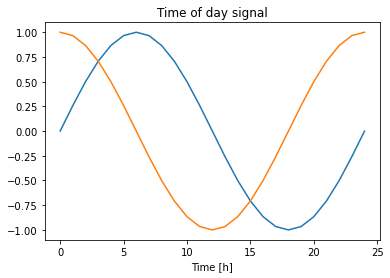

In [14]:
plt.plot(np.array(df['Hourly sin'])[:25])
plt.plot(np.array(df['Hourly cos'])[:25])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

Text(0.5, 1.0, 'Year signal')

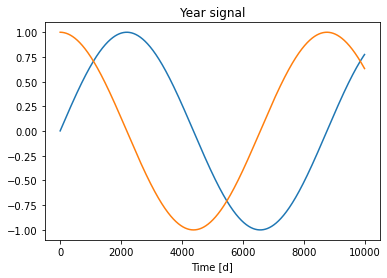

In [21]:
plt.plot(np.array(df['Daily sin'][:10000]))
plt.plot(np.array(df['Daily cos'][:10000]))
plt.xlabel('Time [d]')
plt.title('Year signal')

Изучение семантики в колонках с погодой. Какие слова и как часто встречаются

In [16]:
def count_sep_words(df_col,split_by = ','):
    u_w = df_col.str.split(pat=split_by,expand=True) # получаем датафрейм с разбитыми в отдельные колонки сплитами
    u_w = u_w.values.ravel('K') # переводим в одномерный список (numpy.1d-array)
    u_w = u_w[u_w != np.array(None)] # фильтруем пустые сплиты
    u_w = np.char.strip(u_w.astype('str')) # убираем лишние пробелы
    u_w = pd.value_counts(u_w)
    with pd.option_context('display.max_rows', None):
        print(u_w)

count_sep_words(df["weather_fact"])


ясно                    8361
ветер                   6858
пасм                    6347
пасмурно                4992
дождь                   4589
облачно                 3866
п/обл                   2608
дымка                   2131
пер.обл.                1142
малообл                 1104
обл                      991
ветерок                  826
обл с пр                 769
снег                     753
туман                    727
морось                   690
малообл.                 531
ливень                   509
обл.                     226
гроза                    209
обл с проясн             183
пасм.                    171
душно                    141
снежок                   114
вр.дождь                 104
солнечно                  96
дождик                    88
обл с пр.                 87
метель                    84
слаб.дождь                78
прояснения                68
хол.ветер                 63
малооблачно               60
тепло                     60
снегопад      

In [17]:
print("\nКолонка с предсказанной погодой:")
count_sep_words(df["weather_pred"].dropna().replace("?",""))


Колонка с предсказанной погодой:
пасм                      11568
ветер                      9074
ясно                       5619
п/обл                      5358
обл                        2383
обл с пр                   2316
пасмурно                   1833
облачно                    1740
пер.обл.                   1608
ветерок                    1425
дождь                      1360
малообл                    1110
24%                        1014
малообл.                    692
14%                         420
12%                         396
обл с проясн                378
пасм.                       357
обл.                        291
11%                         285
ветрище                     282
16%                         261
19%                         243
23%                         231
гроза                       231
18%                         228
9%                          213
возм.дождь                  192
0                           179
снег                        171
21%   

In [18]:
def parse_weather_column(keywords:list,src_column_name:str,target_column_name:str,df):
  '''
  Функция для парсинга отдельных столбцов, ищет вхождение переданных ключевых слов в строке и пишет в новую колонку найденное  слово или пустую строку
  :keywords: -список ключевых слов. Ищутся по порядку перебором , поэтому лучше указывать сначала длинные слова, а потом их подстроки
  (например, если первым ключом будет "ветер", то вместо "ветерок" будет найден "ветер")
  :src_column_name: - название столбца, в котором идет поиск
  :target_column_name: - желаемое название нового столбца
  :df: - объект датафрейма, в котором  исходная колонка
  return копия датафрейма с добавленным новым столбцом(функция не inplace, перезаписывайте при надобности свой датафрейм)
  '''
  def find_kword(row_string):
      nonlocal keywords
      if isinstance(row_string,str):
        for k in keywords:
          if k in row_string:
            return k
      return ""
  found_list = [find_kword(row) for row in df[src_column_name] ]
  new_df = df.copy()
  new_df[target_column_name] = found_list
  return new_df

df  = parse_weather_column(["ветерок","ветрище","ветер"],"weather_fact","wind",df)

df.sample(10)

,date,time,target,temp,temp_pred,weather_pred,weather_fact,Hourly sin,Hourly cos,Daily sin,Daily cos,wind
23356,2021-08-31,4,317.584,15.1,12.0,"проясн, 60%","дождь, ветер",0.866025,0.500000,-0.859978,-0.510330,ветер
22539,2021-07-28,3,316.462,16.3,17.0,"п/обл, 12%",ясно,0.707107,0.707107,-0.434620,-0.900614,
19969,2021-04-12,1,419.504,11.9,11.0,пасм,облачно,0.258819,0.965926,0.984150,-0.177339,
25525,2021-11-29,13,671.947,0.6,2.0,"пасм, 80% снег",мелкий снег,-0.258819,-0.965926,-0.524105,0.851653,
8071,2019-12-03,7,493.187,0.4,0.0,"обл с пр, ветер",малообл,0.965926,-0.258819,-0.475923,0.879487,
22739,2021-08-05,11,471.462,20.4,22.0,ясно,ясно,0.258819,-0.965926,-0.558829,-0.829283,
34167,2022-11-24,15,678.986,-2.5,-2.0,пасмурно,"пасм, дымка",-0.707107,-0.707107,-0.597529,0.801847,
19610,2021-03-28,2,426.714,2.5,4.0,"пасм, 35%",дождь,0.500000,0.866025,0.996878,0.078961,
15315,2020-09-30,3,305.402,8.9,9.0,п/обл,ясно,0.707107,0.707107,-0.999872,-0.016030,
5749,2019-08-28,13,473.536,30.0,28.0,ясно,ясно,-0.258819,-0.965926,-0.831171,-0.556017,


In [19]:
df[["weather_fact","wind"]].sample(10)

,weather_fact,wind
33088,"ясно, ветерок",ветерок
13354,пасмурно,
14242,ясно,
8900,морось,
25650,"пасм, снег",
8100,"пасм, дождь",
32523,"пасм, дождь",
24266,ясно,
7240,облачно,
29844,"п/обл, ветер",ветер


Переводим колонку ветра в числовой формат с нужной градацией силы ветра

In [23]:
wind_map = {
    "": 0,
    "ветерок": 0.5,
    "ветер": 1,
    "ветрище":1.5
}
df["wind"] = df["wind"].map(wind_map)
df[["weather_fact","wind"]].sample(10)

,weather_fact,wind
32637,"пасм, дождь",0.0
32581,ливн.дождь,0.0
12856,ясно,0.0
34924,дымка,0.0
3414,пасмурно,0.0
24249,ясно,0.0
14005,ясно,0.0
1636,"пасм, дождь",0.0
34533,"пасм, туман",0.0
21214,ясно,0.0


In [27]:
df.to_csv("../data/numeric_features.csv",float_format='%.5f',mode='w')